In [1]:
# Importing libraries
from controllers import PID
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from IPython.display import display
import torch
import matplotlib.pyplot as plt
from Environment.Dynamics.Quadrotor import Quadrotor
from Test.test_rl import main


# 1. PID controller

The formula of the PID controller is -
$$F(t) = K_p e(t) + K_I \int_0^t e(t) dt + K_d \frac{de}{dt}$$

Initial angular velocities (deg/s):
[-6.7966105  -1.14243381  9.80315131]
Total magnitude of angular velocity (deg/s)
11.983356997248192


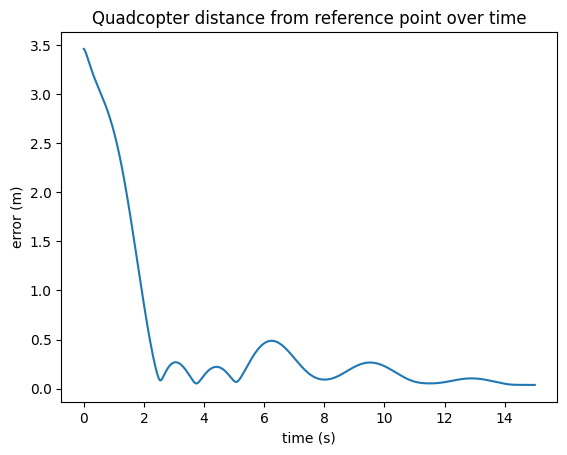

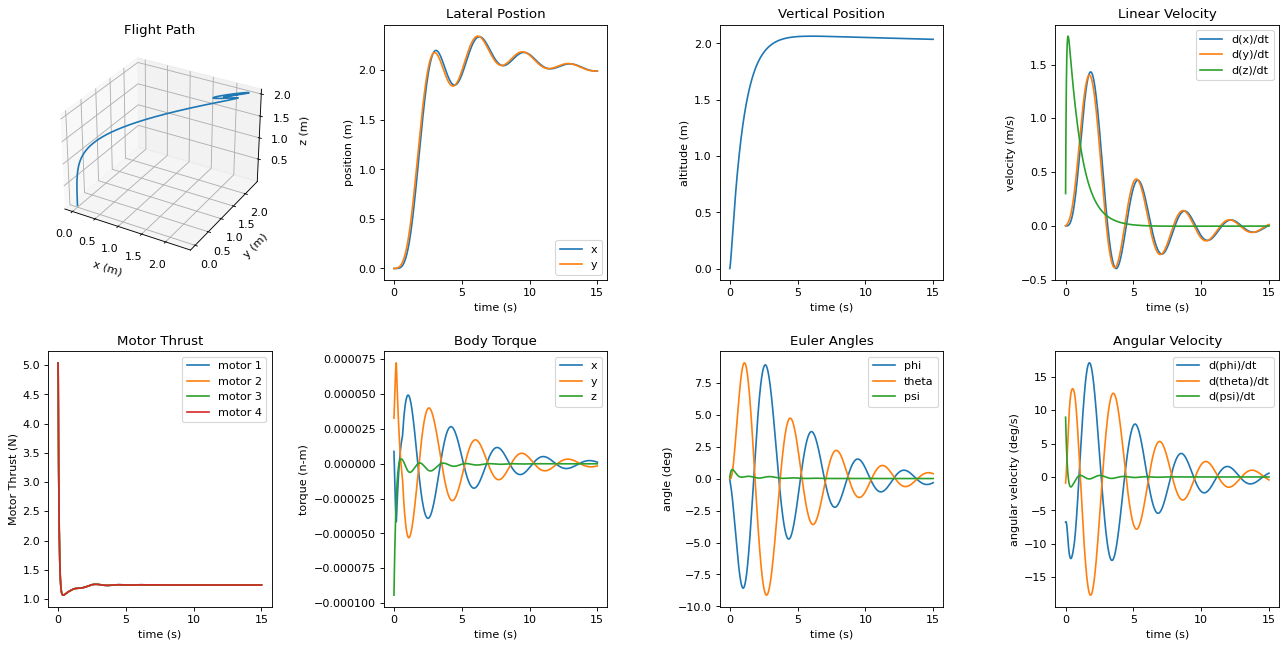

In [2]:
#sim run time
sim_start = 0 #start time of simulation
sim_end = 15 #end time of simulation in sec
dt = 0.01 #step size in sec
time_index = np.arange(sim_start, sim_end + dt, dt)

# Initial conditions
r_ref = np.array([2., 2., 2.]) # desired position [x, y, z] in inertial frame - meters

#initial conditions
#pos = np.array([0., 0., 3.]) # starting location [x, y, z] in inertial frame - meters
#pos = [0.5, 1., 2.] # starting location [x, y, z] in inertial frame - meters
pos = [0., 0., 0.] # starting location [x, y, z] in inertial frame - meters
vel = np.array([0., 0., 0.]) #initial velocity [x; y; z] in inertial frame - m/s
ang = np.array([0., 0., 0.]) #initial Euler angles [phi, theta, psi] relative to inertial frame in deg


# Add initial random roll, pitch, and yaw rates
deviation = 10 # magnitude of initial perturbation in deg/s
random_set = np.array([random.random(), random.random(), random.random()])
ang_vel = np.deg2rad(2* deviation * random_set - deviation) #initial angular velocity [phi_dot, theta_dot, psi_dot]
#ang_vel = np.array([0.0, 0.0, 0.0]) #initial angular velocity [phi_dot, theta_dot, psi_dot]

ang_vel_init = ang_vel.copy()  #record for later display

gravity = 9.8 # acceleration due to gravity, m/s^2

# Gains for position controller
Kp_pos = [.95, .95, 15.] # proportional [x,y,z]
Kd_pos = [1.8, 1.8, 15.]  # derivative [x,y,z]
Ki_pos = [0.2, 0.2, 1.0] # integral [x,y,z]
Ki_sat_pos = 1.1*np.ones(3)  # saturation for integral controller (prevent windup) [x,y,z]

# Gains for angle controller
Kp_ang = [6.9, 6.9, 25.] # proportional [x,y,z]
Kd_ang = [3.7, 3.7, 9.]  # derivative [x,y,z]
Ki_ang = [0.1, 0.1, 0.1] # integral [x,y,z]
Ki_sat_ang = 0.1*np.ones(3)  # saturation for integral controller (prevent windup) [x,y,z]

# Create quadcotper with position and angle controller objects
quadcopter = Quadrotor.Quadrotor(pos,vel,ang,ang_vel,r_ref)
pos_controller = PID.PID_Controller(Kp_pos, Kd_pos, Ki_pos, Ki_sat_pos, dt)
angle_controller = PID.PID_Controller(Kp_ang, Kd_ang, Ki_ang, Ki_sat_ang, dt)

# Initialize results arrays
total_error = []
position_total = []
total_thrust = []

def initialize_results(res_array, num):
    for i in range(num):
        res_array.append([])


position = []
initialize_results(position,3)

velocity = []
initialize_results(velocity,3)

angle = []
initialize_results(angle,3)

angle_vel = []
initialize_results(angle_vel,3)

motor_thrust = []
initialize_results(motor_thrust,4)

body_torque = []
initialize_results(body_torque,3)



# Simulation
for time in enumerate(time_index):
    # print(time)
    #find position and velocity error and call positional controller
    pos_error = quadcopter.getPoseError(quadcopter.pos)
    vel_error = quadcopter.getLnrVelError(quadcopter.lnr_vel)
    des_acc = pos_controller.control_update(pos_error,vel_error)
    
    #Modify z gain to include thrust required to hover
    des_acc[2] = (gravity + des_acc[2])/(math.cos(quadcopter.ort[0]) * math.cos(quadcopter.ort[1]))
    
    #calculate thrust needed  
    thrust_needed = quadcopter.mass * des_acc[2]
    
    #Check if needed acceleration is not zero. if zero, set to one to prevent divide by zero below
    mag_acc = np.linalg.norm(des_acc)
    if mag_acc == 0:
        mag_acc = 1
    
    #use desired acceleration to find desired angles since the quad can only move via changing angles
    ang_des = [math.asin(-des_acc[1] / mag_acc / math.cos(quadcopter.ort[1])),
        math.asin(des_acc[0] / mag_acc),
         0]

    #check if exceeds max angle
    mag_angle_des = np.linalg.norm(ang_des)
    if mag_angle_des > quadcopter.max_angle:
        ang_des = (ang_des / mag_angle_des) * quadcopter.max_angle

    #call angle controller
    quadcopter.ort_des = ang_des
    ang_error = quadcopter.getOrtError(quadcopter.ort)
    ang_vel_error = quadcopter.getAngVelError(quadcopter.ang_vel)
    tau_needed = angle_controller.control_update(ang_error, ang_vel_error)
    #Find motor speeds needed to achieve desired linear and angular accelerations
    quadcopter.getDesSpeed(thrust_needed, tau_needed)
    # Step in time and update quadcopter attributes
    quadcopter.step()

    # Record key attributes for plotting
    position_total.append(np.linalg.norm(quadcopter.pos))

    position[0].append(quadcopter.pos[0])
    position[1].append(quadcopter.pos[1])
    position[2].append(quadcopter.pos[2])

    velocity[0].append(quadcopter.lnr_vel[0])
    velocity[1].append(quadcopter.lnr_vel[1])
    velocity[2].append(quadcopter.lnr_vel[2])

    angle[0].append(np.rad2deg(quadcopter.ort[0]))
    angle[1].append(np.rad2deg(quadcopter.ort[1]))
    angle[2].append(np.rad2deg(quadcopter.ort[2]))

    angle_vel[0].append(np.rad2deg(quadcopter.ang_vel[0]))
    angle_vel[1].append(np.rad2deg(quadcopter.ang_vel[1]))
    angle_vel[2].append(np.rad2deg(quadcopter.ang_vel[2]))

    motor_thrust[0].append(quadcopter.speeds[0]*quadcopter.k1)
    motor_thrust[1].append(quadcopter.speeds[1]*quadcopter.k1)
    motor_thrust[2].append(quadcopter.speeds[2]*quadcopter.k1)
    motor_thrust[3].append(quadcopter.speeds[3]*quadcopter.k1)

    body_torque[0].append(quadcopter.tau[0])
    body_torque[1].append(quadcopter.tau[1])
    body_torque[2].append(quadcopter.tau[2])

    total_thrust.append(quadcopter.k1 * np.sum(quadcopter.speeds))

    # Positional error
    r_error = quadcopter.pos_des - quadcopter.pos
    total_error.append(np.linalg.norm(r_error))



# Write random values to screen
def write_init_ang_vel_to_screen():
    ''' 
    The program initializes with a random perturbation in angular velocity on the vehicle. 
    This simulates a wind disturbace.
    This is a display of the random disturbance
    '''
    print('Initial angular velocities (deg/s):')
    print(np.rad2deg(ang_vel_init))
    print('Total magnitude of angular velocity (deg/s)')
    print(np.linalg.norm(np.rad2deg(ang_vel_init)))

# Visualising the results
def error_plot():
    ''' Plots to the magnitude of the position error vector (m)'''
    plt.plot(time_index, total_error)
    plt.title('Quadcopter distance from reference point over time')
    plt.xlabel('time (s)')
    plt.ylabel('error (m)')
    plt.show()

def simple_plot():
    ''' 
    Plots the laterial position, vertical position, and Euler angles over time.
    This is a quick plot for trouble shooting
    '''
    fig =  plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    # Lateral position plots
    axes = fig.add_subplot(1, 3, 1)
    #axes.plot(time_index, position[0], label= 'x')
    #axes.plot(time_index, position[1], label= 'y')
    axes.plot(position[0], position[1])
    axes.set_title('Lateral Postion Over Time')
    axes.set_xlabel('x-position (m)')
    axes.set_ylabel('y-position (m)')
    axes.legend()

    # Vertical position plot
    axes = fig.add_subplot(1, 3, 2)
    axes.plot(time_index, position[2], label= 'z')
    axes.set_title('Vertical Position Over Time')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('altitude (m)')

    # Angles over time
    axes = fig.add_subplot(1, 3, 3)
    axes.plot(time_index, angle[0], label= 'phi')
    axes.plot(time_index, angle[1], label= 'theta')
    axes.plot(time_index, angle[2], label= 'psi')
    axes.set_title('Euler Angles Over Time')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('angle (deg)')
    axes.legend()

    plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=2.0)
    plt.show()


def total_plot():
    '''
    This is a full plot of the results. It will plot the 3D flight path, vertical and lateral positions,
    lateral velocity, motor thrusts, body torques, Euler angles, and angular velocity of the vehicle.
    '''

    fig =  plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

    # 3D Flight path
    axes = fig.add_subplot(2, 4, 1, projection='3d')
    axes.plot(position[0], position[1], position[2])
    axes.set_title('Flight Path')
    axes.set_xlabel('x (m)')
    axes.set_ylabel('y (m)')
    axes.set_zlabel('z (m)')

    # Lateral position plots
    axes = fig.add_subplot(2, 4, 2)
    axes.plot(time_index, position[0], label= 'x')
    axes.plot(time_index, position[1], label= 'y')
    axes.set_title('Lateral Postion')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('position (m)')
    axes.legend()

    # Vertical position plot
    axes = fig.add_subplot(2, 4, 3)
    axes.plot(time_index, position[2], label= 'z')
    axes.set_title('Vertical Position')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('altitude (m)')

    # Lateral velocity plots
    axes = fig.add_subplot(2, 4, 4)
    axes.plot(time_index, velocity[0], label= 'd(x)/dt')
    axes.plot(time_index, velocity[1], label= 'd(y)/dt')
    axes.plot(time_index, velocity[2], label= 'd(z)/dt')
    axes.set_title('Linear Velocity')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('velocity (m/s)')
    axes.legend()

    # Motor speed plots
    axes = fig.add_subplot(2, 4, 5)
    axes.plot(time_index, motor_thrust[0], label= 'motor 1')
    axes.plot(time_index, motor_thrust[1], label= 'motor 2')
    axes.plot(time_index, motor_thrust[2], label= 'motor 3')
    axes.plot(time_index, motor_thrust[3], label= 'motor 4')
    axes.set_title('Motor Thrust')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Motor Thrust (N)')
    axes.legend()

    # Body torque over time
    axes = fig.add_subplot(2, 4, 6)
    axes.plot(time_index, body_torque[0], label= 'x')
    axes.plot(time_index, body_torque[1], label= 'y')
    axes.plot(time_index, body_torque[2], label= 'z')
    axes.set_title('Body Torque')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('torque (n-m)')
    axes.legend()

    # Angles over time
    axes = fig.add_subplot(2, 4, 7)
    axes.plot(time_index, angle[0], label= 'phi')
    axes.plot(time_index, angle[1], label= 'theta')
    axes.plot(time_index, angle[2], label= 'psi')
    axes.set_title('Euler Angles')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('angle (deg)')
    axes.legend()

    # Angular velocity over time
    axes = fig.add_subplot(2, 4, 8)
    axes.plot(time_index, angle_vel[0], label= 'd(phi)/dt')
    axes.plot(time_index, angle_vel[1], label= 'd(theta)/dt')
    axes.plot(time_index, angle_vel[2], label= 'd(psi)/dt')
    axes.set_title('Angular Velocity')
    axes.set_xlabel('time (s)')
    axes.set_ylabel('angular velocity (deg/s)')
    axes.legend()


    plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=2.0)
    plt.show()
    
write_init_ang_vel_to_screen()
error_plot()
#simple_plot()
total_plot()

# 1. Reinforcement learning algorithms -

We compare PID controller againts 4 reinforcement learning algorithms (DDPG, TD3, SAC and SoftQ).

## 1.1 Deep Deterministic policy gradient

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). 

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Replay buffer
One challenge when using neural networks for reinforcement learning is that most optimization algorithms assume that **the samples are independently and identically distributed**. When the samples are generated from exploring sequentially in an environment this assumption no longer holds. The authors used a **replay buffer** to address these issues. Transitions were sampled from the environment according to the exploration policy and the tuple $(s_t, a_t, r_t, s_{t+1})$ was stored in the replay buffer. At each timestep the actor and critic are updated by sampling a minibatch uniformly from the buffer. It allows to benefit from learning across a set of **uncorrelated** transitions.

### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target netwokrs is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

The target pose is : [-3  0  0]
The position error at the end : 0.9747446648800362
The orientation error at the end : 0.030019504168358337
The velocity error at the end : 0.03345374108733388
The end pose is : [-3.80821997 -0.32744727  0.43552948]


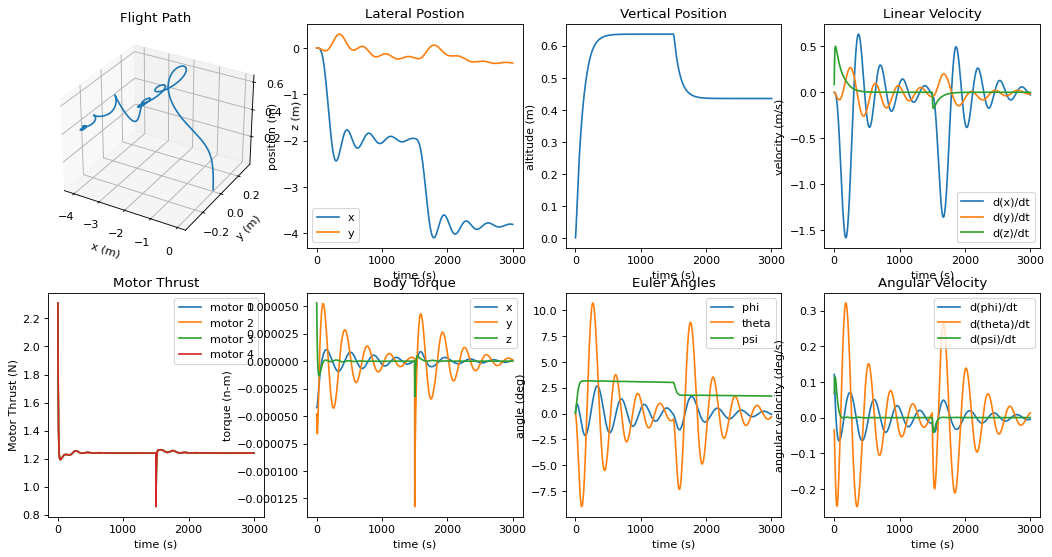

In [3]:
algorithm = "DDPG"

main(algorithm)

## 1.2 Twin Delayed DDPG (TD3)

[Fujimoto, Scott, Herke van Hoof, and David Meger. "Addressing function approximation error in actor-critic methods." arXiv preprint arXiv:1802.09477 2018.](https://arxiv.org/pdf/1802.09477.pdf)

In value-based reinforcement learning methods, function approximation errors are known to lead to overestimated value estimates and suboptimal policies. However, similar issues with actor-critic methods in continuous control domains have been largely left untouched (See paper for detailed description). To solve this problem, this paper proposes *a clipped Double Q-learning*. In addtion, this paper contains a number of components that address variance reduction.

The author's modifications are applied to actor-critic method for continuous control, Deep Deterministic Policy Gradient algorithm ([DDPG](https://arxiv.org/pdf/1509.02971.pdf)), to form the *Twin Delayed Deep Deterministic policy gradient algorithm (TD3)*.

### Double Q-learning
In Double DQN ([Van Hasselt et al., 2016](https://arxiv.org/pdf/1509.06461.pdf)), the authors propose using the target network as one of the value estimates, and obtain a policy by greedy maximization of the current value network rather than the target network. In an actor-critic setting, an analogous update uses the current policy rather than the target policy in the learning target. However, with the slow-changing policy in actor-critic, the current and target networks were too similar to make an independent estimation, and offered little improvement. Instead, the original Double Q-learning formulation can be used, with a pair of actors $(\pi_{\phi_1}, \pi_{\phi_2})$ and critics $(Q_{\theta_1}, Q_{\theta_2})$, where $\pi_{\phi_1}$ is optimized with respect to $Q_{\theta_1}$ and $\pi_{\phi_2}$ with respect to $Q_{\theta_2}$:

$$
y_1 = r + \gamma Q_{\theta'_2} (s' , \pi_{\phi_1}(s')) \\
y_2 = r + \gamma Q_{\theta'_1} (s' , \pi_{\phi_2}(s'))
$$

### A clipped Double Q-learning
The critics are not entirely independent, due to the use of the opposite critic in the learning targets, as well as the same replay buffer. As a result, for some states we will have $Q_{\theta'_2}(s, \pi_{\phi_1}) > Q_{\theta'_1}(s, \pi_{\phi_1})$. This is problematic because $Q_{\theta'_1}(s, \pi_{\phi_1})$ will generally overestimate the true value, and in certain areas of the state space the overestimation will be further exaggerated. To address this problem, the authors propose to take the minimum between the two estimates:

$$
y_1 = r + \gamma \underset{i=1,2}{\min} Q_{\theta'_i} (s' , \pi_{\phi_1}(s'))
$$

### Delayed Policy Updates
If policy updates on high-error states cause different behavior, then the policy network should be updated at a lower frequency than the value network, to first minimize error before introducing a policy update. The authors propose delaying policy updates until the value error is as small as possible.

### Target Policy Smoothing Regularization
When updating the critic, a learning target using a deterministic policy is highly susceptible to in accuracies induced by function approximation error, increasing the variance of the target. This induced variance can be reduced through regularization. The authors propose that fitting the value of a small area around the target action

$$
y = r + E_\epsilon [Q_{\theta'}(s', \pi_{\phi '}(s') + \epsilon],
$$

would have the benefit of smoothing the value estimate by bootstrapping off of similar state-action value estimates. In practice, this makes below:

$$
y = r + \gamma Q_{\theta '}(s', \pi_{\phi '}(s') + \epsilon), \\
\epsilon \sim \text{clip} (\mathcal(N)(0, \sigma), -c, c),
$$

where the added noise is clipped to keep the target close tothe original action.

The target pose is : [3 1 0]
The position error at the end : 0.9405551561471868
The orientation error at the end : 0.03550789776935547
The velocity error at the end : 0.004444217905425446
The end pose is : [2.2329374  1.09483065 0.53597212]


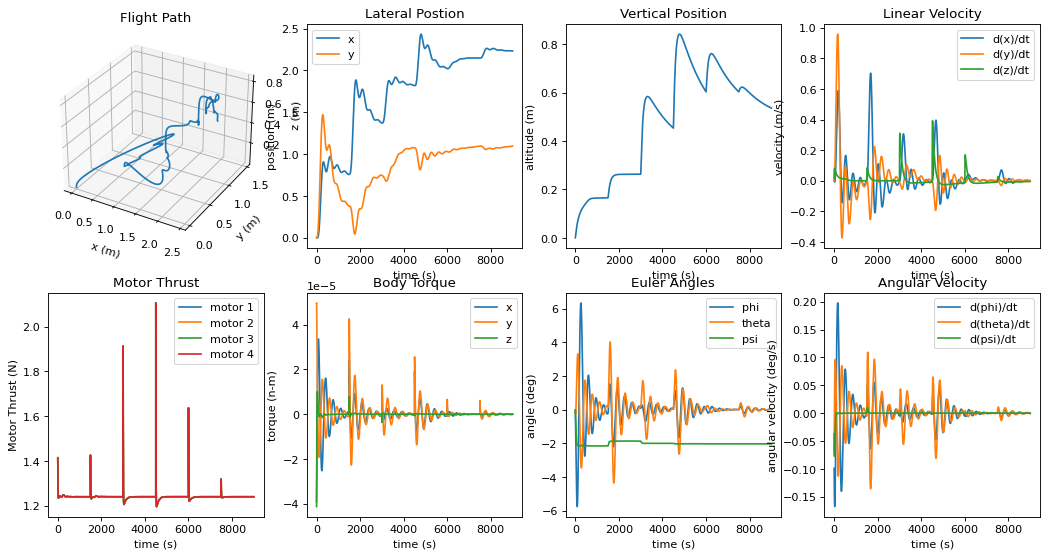

In [6]:
algorithm = "TD3"

main(algorithm)

## 1.3 Soft Actor Critic (SAC)

1. [T. Haarnoja et al., "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." arXiv preprint arXiv:1801.01290, 2018.](https://arxiv.org/pdf/1801.01290.pdf)

The main purpose of SAC is to maximize the actor's entropy while maximizing expected reward. We can expect both sample efficient learning and stability because maximizing entropy provides a substantial improvement in exploration and robustness.

As an extension of standard RL's objective function $\sum_t \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t)]$, let's consider a more general maximum entropy objective which favors stochastic policies by augmenting the objective with the expected entropy of the policy over $\rho_\pi (s_t)$:

$$J(\pi) = \sum_{t=0}^T \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t) + \alpha H(\pi(\cdot | s_t))].$$

The temperature parameter $\alpha$ determines the relative importance of the entropy term against the reward, and thus controls the stochasticity of the optimal policy. By this objective, the policy can explore more widely and capture multiple modes of near-optimal behavior. In conclusion, it considerably improves learning speed over other methods that optimize the conventional RL objective function.

In the paper, the authors show that *Soft Policy Iteration* guarantees convergence based on a tabular setting (4.1), and they extend it to a practical approximation for large continuous domains (4.2). Firstly, the soft value function is trained to minimize the squared residual error:

$$J_V (\psi) = \mathbb{E}_{s_t \sim D} \big[ \frac{1}{2}(v_\psi (s_t) - \mathbb{E}_{a_t \sim \pi_\phi} [Q_\theta(s_t, a_t) - \log_{\pi_\phi}(a_t | s_t)])^2 \big],$$

where $D$ is the distribution of previously sampled states and actions, or a replay buffer. Second, the soft Q-function parameters can be trained to minimize the soft Bellman residual:

$$J_Q (\theta) = \mathbb{E}_{(s_t, a_t) \sim D} \big[ \frac{1}{2} \big( Q_\theta(s_t, a_t) - \hat{Q}(s_t, a_t) \big)^2 \big],$$

with $\hat{Q}(s_t, a_t) = r(s_t, a_t) + \gamma \mathbb{E}_{s_{t+1} \sim \rho} [V_{\tilde{\psi}} (s_{t+1})].$

Finally, the policy paramameters can be learned by directly minimizing the following expected KL-divergence:

$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D} \big[ D_{KL} \big( \pi_{\phi} (\cdot | s_t) \| \frac{\exp(Q_{\theta}(s_t, \cdot))}{Z_\theta(s_t)} \big) \big].$$

We can rewirte the objective as

$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D, \epsilon_t \sim N} [ \log_{\pi_\phi}(f_\phi(\epsilon_t ; s_t) | s_t) - Q_\theta (s_t, f_\phi (\epsilon_t ; s_t))],$$

where $\pi_\phi$ is defined implicitly in terms of $f_\phi$, and the partition function is independent of $\phi$ and can thus be omitted.

One thing to note is that the authors suggest to use two Q-functions to mitigate positive bias in the policy improvement step that is known to degrade performance of value based methods. In particular, we parameterize two Q-functions, with parameters $\theta_i$, and train them independently to optimize $J_Q(\theta_i)$. We then use the minimum of the Q-functions for the value gradient and policy gradient. Two Q-functions can significantly speed up training, especially on harder tasks.

-------LOADING NETWORK -------
The target pose is : [3 0 1]
The position error at the end : 0.9900243125354883
The orientation error at the end : 0.010974715980764684
The velocity error at the end : 0.0024108846441355243
The end pose is : [2.10624358 0.39262263 1.16490929]


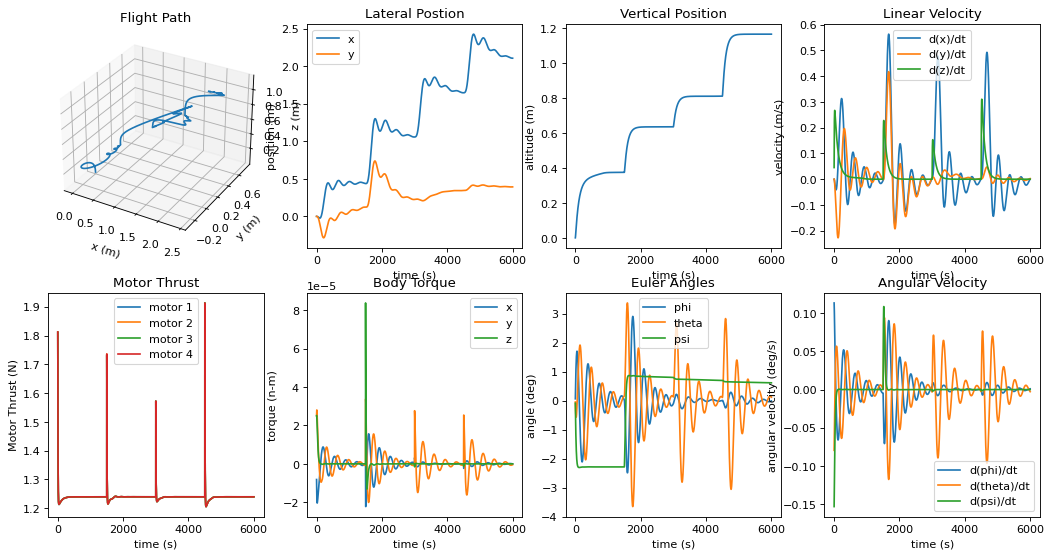

In [13]:
algorithm = "SAC"

main(algorithm)

## 1.4 Soft Qlearning (SoftQ)

With normal Q-learning, we define our backup operator $\mathcal{T}$ as follows
$$
\mathcal{T}Q = \mathbb{E}_{r,s'} \big[ r + \gamma \mathbb{E}_{a'\sim\pi}[Q(s', a')] \big]
$$

In the max-entropy setting, we'll have to add in an entropy bonus to the reward signal and simplify accordingly

\begin{align*}
\mathcal{T}Q &= \mathbb{E}_{r,s'} \big[ r + \gamma \mathbb{E}_{a'}[Q(s', a')] - \alpha D_{KL} \big( \pi(\cdot|s') \;\Vert\; \bar{\pi}(\cdot|s') \big) \big] \\
&= \mathbb{E}_{r,s'} \big[ r + \gamma \alpha \log \mathbb{E}_{a'\sim\bar{\pi}}[e^{Q(s',a')/\alpha}] \big]
\end{align*}

See equations 11 and 13 from the paper (which rely on equations 2-6) if you want to see just how exactly that simplication works. To actually perform the optimization step $Q \gets \mathcal{T}Q$, we'll minimize the mean squared error between our current $Q$ and an estimate of $\mathcal{T}Q$. Our regression targets can be defined

\begin{align*}
y &= r + \gamma \alpha \log \mathbb{E}_{a'\sim\bar{\pi}} \big[ e^{Q(s', a') / \alpha} \big] \\
&= r + \gamma V(s')
\end{align*}

Using Boltzmann backups instead of the traditional Q-learning backups is what transforms normal Q-learning into what's conventionally called "soft" Q-learning. That's really all there is to it.

The target pose is : [ 1 -1  0]
The position error at the end : 0.7575161208922553
The orientation error at the end : 0.0990397929815993
The velocity error at the end : 0.13131254955596716
The end pose is : [ 0.76251098 -1.38050549  0.61044673]


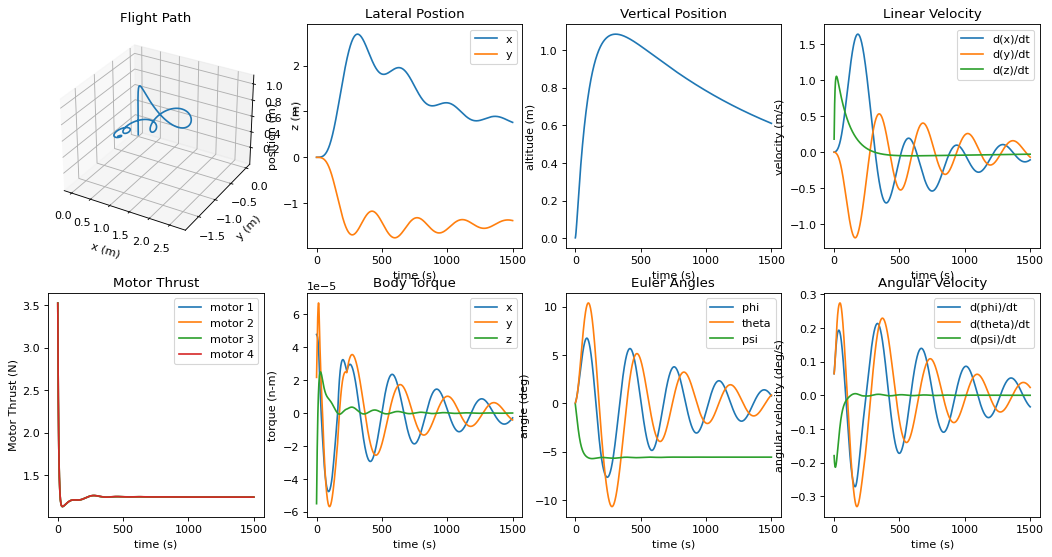

In [15]:
algorithm = "SoftQ"

main(algorithm)

## 1.5  Safe reinforcement learning as an adversarial game of actor-critics (SAAC)

The target pose is : [ 2  1 -4]
The position error at the end : 0.9230612308129811
The orientation error at the end : 0.025501303415308284
The velocity error at the end : 0.01722600211374489
The end pose is : [ 1.55038181  1.5931672  -3.45407125]


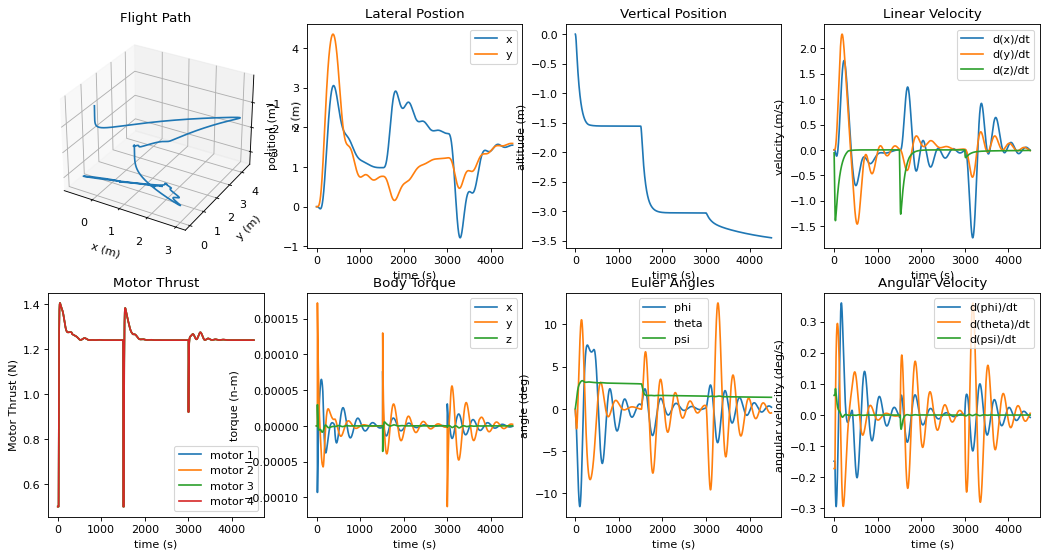

In [16]:
algorithm = "SAAC"

main(algorithm)

## 1.6  Reachability Constrained Reinforcement Learning (RCRL)

The target pose is : [-1 -4  0]
The position error at the end : 4.912461334667743
The orientation error at the end : 0.0009284197455848795
The velocity error at the end : 0.00011452045833301151
The end pose is : [ 0.3133946   0.56433079 -1.2546535 ]


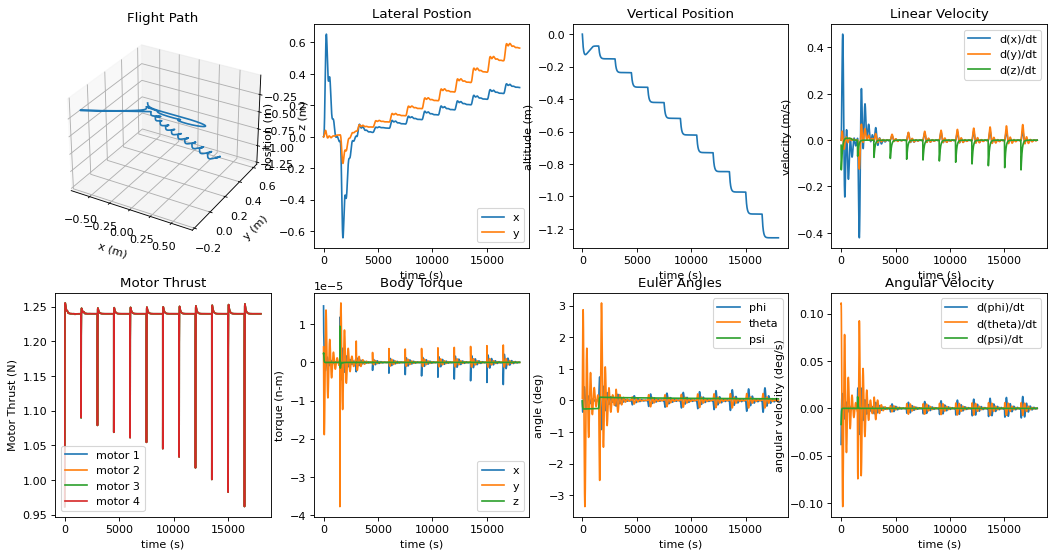

In [17]:
algorithm = "RCRL"

main(algorithm)

## 1.7  Unrolling Safety Layer (USL)

The target pose is : [-3  3  3]
The position error at the end : 4.9470998153605406
The orientation error at the end : 0.03266125333282437
The velocity error at the end : 0.001799662954317372
The end pose is : [-6.90816877  0.02920369  2.38813175]


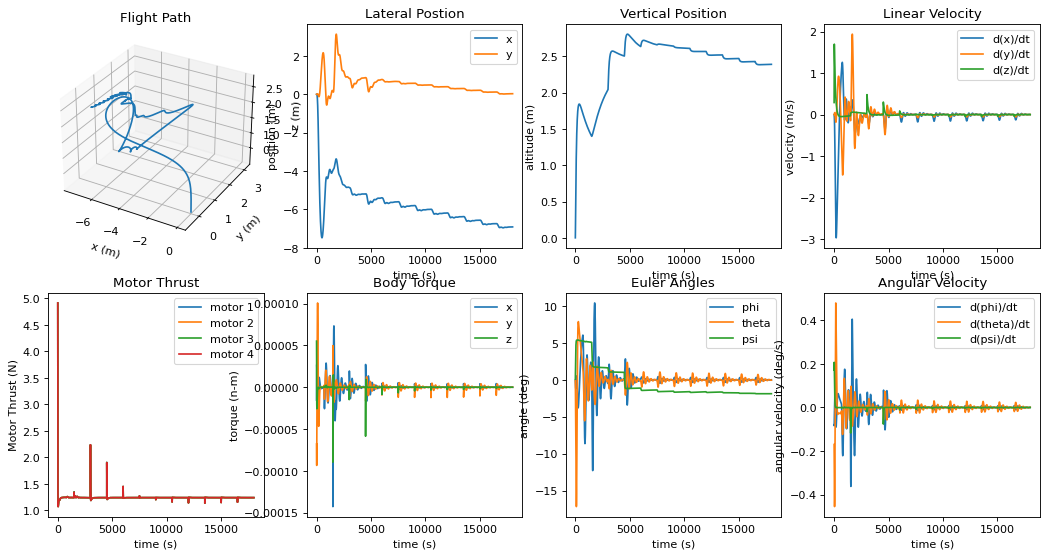

In [22]:
algorithm = "USL"

main(algorithm)

The target pose is : [ 4 -4  0]
The position error at the end : 0.6854741263812647
The orientation error at the end : 0.03596693643482754
The velocity error at the end : 0.035771864631388955
The end pose is : [ 3.96035625 -3.43139591  0.38077886]


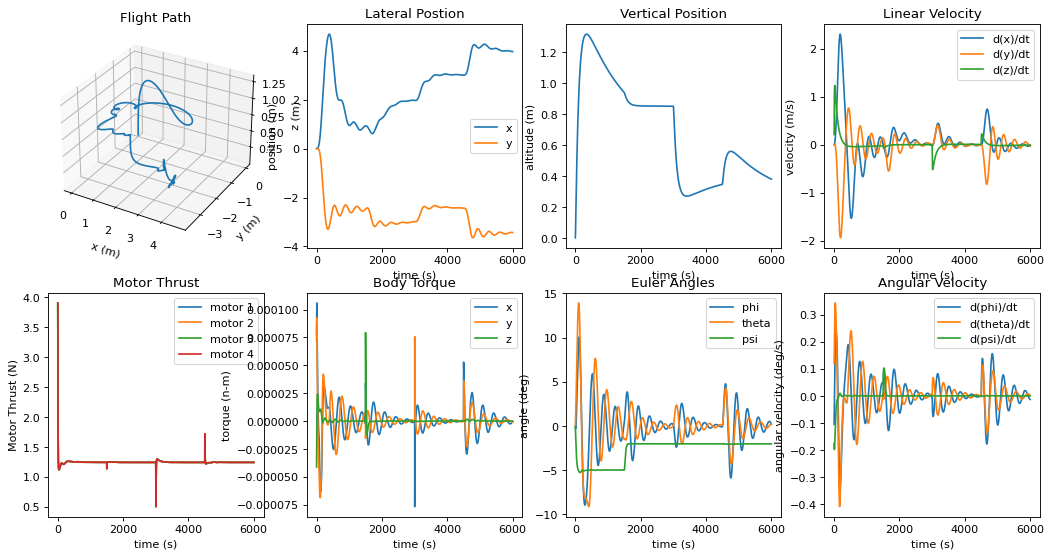

In [3]:
algorithm = "IDEA4"

main(algorithm)